# Full Stack Practice of LLM Training - LLM Model Setup @ RLChina 2024

- Author: [Cheng Deng](https://www.cdeng.net/)[✉️]((davendw49@gmail.com), [Jun Wang](http://www0.cs.ucl.ac.uk/staff/jun.wang/)

---
## Main Task

In this section, we'll break down the key components of LLMs and demonstrate how to code them together. Instead of diving deeply into every module, we’ll focus on the overall structure and how to assemble a decoder-only, GPT-style language model.

This section serves as a bridge between the data preparation and model training stages. Often, this phase is where innovation and creativity flourish. However, in this notebook, we will simply introduce a basic model to provide a foundational understanding.

![](https://www.cdeng.net/resources/imgs/RLChina24/a.png)

Here is the prerequisite knowledge required:

- Attention mechanism and `Transformers` Model
- Matrix operations in linear algebra
- Basic OS knowledge

## Language Models

### 1. Bigram

In [1]:
# 构建一个玩具数据集
corpus = [ "我喜欢吃苹果",
        "我喜欢吃香蕉",
        "她喜欢吃葡萄",
        "他不喜欢吃香蕉",
        "他喜欢吃苹果",
        "她喜欢吃草莓"]

In [2]:
# 定义一个分词函数，将文本转换为单个字符的列表
def tokenize(text):
 return [char for char in text] # 将文本拆分为字符列表
# 对每个文本进行分词，并打印出对应的单字列表
print("单字列表:")
for text in corpus:
    tokens = tokenize(text)
    print(tokens)

单字列表:
['我', '喜', '欢', '吃', '苹', '果']
['我', '喜', '欢', '吃', '香', '蕉']
['她', '喜', '欢', '吃', '葡', '萄']
['他', '不', '喜', '欢', '吃', '香', '蕉']
['他', '喜', '欢', '吃', '苹', '果']
['她', '喜', '欢', '吃', '草', '莓']


In [3]:
# 定义计算 N-Gram 词频的函数
from collections import defaultdict, Counter # 导入所需库
def count_ngrams(corpus, n):
    ngrams_count = defaultdict(Counter)  # 创建一个字典，存储 N-Gram 计数
    for text in corpus:  # 遍历语料库中的每个文本
        tokens = tokenize(text)  # 对文本进行分词
        for i in range(len(tokens) - n + 1):  # 遍历分词结果，生成 N-Gram
            ngram = tuple(tokens[i:i+n])  # 创建一个 N-Gram 元组
            prefix = ngram[:-1]  # 获取 N-Gram 的前缀
            token = ngram[-1]  # 获取 N-Gram 的目标单字
            ngrams_count[prefix][token] += 1  # 更新 N-Gram 计数
    return ngrams_count
bigram_counts = count_ngrams(corpus, 2) # 计算 bigram 词频
print("bigram 词频：") # 打印 bigram 词频
for prefix, counts in bigram_counts.items():
    print("{}: {}".format("".join(prefix), dict(counts)))

bigram 词频：
我: {'喜': 2}
喜: {'欢': 6}
欢: {'吃': 6}
吃: {'苹': 2, '香': 2, '葡': 1, '草': 1}
苹: {'果': 2}
香: {'蕉': 2}
她: {'喜': 2}
葡: {'萄': 1}
他: {'不': 1, '喜': 1}
不: {'喜': 1}
草: {'莓': 1}


In [4]:
# 定义计算 N-Gram 出现概率的函数
def ngram_probabilities(ngram_counts):
 ngram_probs = defaultdict(Counter) # 创建一个字典，存储 N-Gram 出现的概率
 for prefix, tokens_count in ngram_counts.items(): # 遍历 N-Gram 前缀
     total_count = sum(tokens_count.values()) # 计算当前前缀的 N-Gram 计数
     for token, count in tokens_count.items(): # 遍历每个前缀的 N-Gram
         ngram_probs[prefix][token] = count / total_count # 计算每个 N-Gram 出现的概率
 return ngram_probs
bigram_probs = ngram_probabilities(bigram_counts) # 计算 bigram 出现的概率
print("\nbigram 出现的概率 :") # 打印 bigram 概率
for prefix, probs in bigram_probs.items():
 print("{}: {}".format("".join(prefix), dict(probs)))


bigram 出现的概率 :
我: {'喜': 1.0}
喜: {'欢': 1.0}
欢: {'吃': 1.0}
吃: {'苹': 0.3333333333333333, '香': 0.3333333333333333, '葡': 0.16666666666666666, '草': 0.16666666666666666}
苹: {'果': 1.0}
香: {'蕉': 1.0}
她: {'喜': 1.0}
葡: {'萄': 1.0}
他: {'不': 0.5, '喜': 0.5}
不: {'喜': 1.0}
草: {'莓': 1.0}


In [5]:
# 定义生成下一个词的函数
def generate_next_token(prefix, ngram_probs):
 if not prefix in ngram_probs: # 如果前缀不在 N-Gram 中，返回 None
    return None
 next_token_probs = ngram_probs[prefix] # 获取当前前缀的下一个词的概率
 next_token = max(next_token_probs,
                    key=next_token_probs.get) # 选择概率最大的词作为下一个词
 return next_token

In [6]:
# 定义生成连续文本的函数
def generate_text(prefix, ngram_probs, n, length=6):
 tokens = list(prefix) # 将前缀转换为字符列表
 for _ in range(length - len(prefix)): # 根据指定长度生成文本
     # 获取当前前缀的下一个词
     next_token = generate_next_token(tuple(tokens[-(n-1):]), ngram_probs)
     if not next_token: # 如果下一个词为 None，跳出循环
         break
     tokens.append(next_token) # 将下一个词添加到生成的文本中
 return "".join(tokens) # 将字符列表连接成字符串

In [9]:
# 输入一个前缀，生成文本
generated_text = generate_text("她", bigram_probs, 2)
print("\n 生成的文本：", generated_text) # 打印生成的文本


 生成的文本： 她喜欢吃苹果


### 2. Word2vec

In [10]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print(" 词汇表：", word_list) # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size) # 输出词汇表大小

 词汇表： ['Student', 'Xiaoxue', 'Mazong', 'is', 'Boss', 'Teacher', 'Niuzong', 'Kage', 'Xiaobing']
 词汇到索引的字典： {'Student': 0, 'Xiaoxue': 1, 'Mazong': 2, 'is': 3, 'Boss': 4, 'Teacher': 5, 'Niuzong': 6, 'Kage': 7, 'Xiaobing': 8}
 索引到词汇的字典： {0: 'Student', 1: 'Xiaoxue', 2: 'Mazong', 3: 'is', 4: 'Boss', 5: 'Teacher', 6: 'Niuzong', 7: 'Kage', 8: 'Xiaobing'}
 词汇表大小： 9


In [11]:
# 生成 CBOW 训练数据
def create_cbow_dataset(sentences, window_size=2):
    data = []# 初始化数据
    for sentence in sentences:
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取上下文词汇，将当前单词前后各 window_size 个单词作为周围词
            context_words = sentence[max(idx - window_size, 0):idx] \
                + sentence[idx + 1:min(idx + window_size + 1, len(sentence))]
            # 将当前单词与上下文词汇作为一组训练数据
            data.append((word, context_words))
    return data
# 使用函数创建 CBOW 训练数据
cbow_data = create_cbow_dataset(sentences)
# 打印未编码的 CBOW 数据样例（前三个）
print("CBOW 数据样例（未编码）：", cbow_data[:3])

CBOW 数据样例（未编码）： [('Kage', ['is', 'Teacher']), ('is', ['Kage', 'Teacher']), ('Teacher', ['Kage', 'is'])]


In [12]:
# 定义 One-Hot 编码函数
import torch # 导入 torch 库
def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx)) # 创建一个长度与词汇表相同的全 0 张量
    tensor[word_to_idx[word]] = 1  # 将对应词的索引设为 1
    return tensor  # 返回生成的 One-Hot 向量
# 展示 One-Hot 编码前后的数据
word_example = "Teacher"
print("One-Hot 编码前的单词：", word_example)
print("One-Hot 编码后的向量：", one_hot_encoding(word_example, word_to_idx))

One-Hot 编码前的单词： Teacher
One-Hot 编码后的向量： tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.])


In [13]:
# 定义 CBOW 模型
import torch.nn as nn # 导入 neural network
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(CBOW, self).__init__()
        # 从词汇表大小到嵌入大小的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size,
                                         embedding_size, bias=False)
        # 从嵌入大小到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size,
                                          voc_size, bias=False)
    def forward(self, X): # X: [num_context_words, voc_size]
        # 生成嵌入：[num_context_words, embedding_size]
        embeddings = self.input_to_hidden(X)
        # 计算隐藏层，求嵌入的均值：[embedding_size]
        hidden_layer = torch.mean(embeddings, dim=0)
        # 生成输出层：[1, voc_size]
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0))
        return output_layer
embedding_size = 2 # 设定嵌入层的大小，这里选择 2 是为了方便展示
cbow_model = CBOW(voc_size,embedding_size)  # 实例化 CBOW 模型
print("CBOW 模型：", cbow_model)

CBOW 模型： CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 0.9192795688907306
Epoch: 200, Loss: 0.9102012105907004
Epoch: 300, Loss: 0.901652473397553
Epoch: 400, Loss: 0.8935942426323891
Epoch: 500, Loss: 0.8859903384000063
Epoch: 600, Loss: 0.8788066416357955
Epoch: 700, Loss: 0.872010466704766
Epoch: 800, Loss: 0.8655717302113771
Epoch: 900, Loss: 0.8594604024042686
Epoch: 1000, Loss: 0.8536493906751275


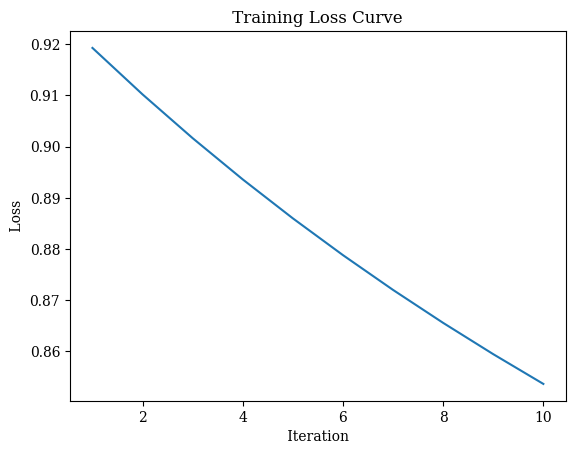

In [22]:
# 训练 Skip-Gram 类
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    for target, context_words in cbow_data:
        # 将上下文词转换为 One-Hot 向量并堆叠
        X = torch.stack([one_hot_encoding(word, word_to_idx) for word in context_words]).float()
        # 将目标词转换为索引值
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long)
        y_pred = cbow_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每 100 轮的损失，并记录损失
      print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(cbow_data)}")
      loss_values.append(loss_sum / len(cbow_data))
# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入 matplotlib
# 绘制二维词向量图
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' Training Loss Curve ') # 图题
plt.xlabel(' Iteration ') # X 轴 Label
plt.ylabel(' Loss ') # Y 轴 Label
plt.show() # 显示图

In [23]:
# 输出 Skip-Gram 习得的词嵌入
print("Skip-Gram 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
 print(f"{word}: {cbow_model.input_to_hidden.weight[:,idx].detach().numpy()}")

Skip-Gram 词嵌入：
Student: [ 3.219618   -0.44209874]
Xiaoxue: [1.6797357 1.8430731]
Mazong: [-0.99265635  2.1662228 ]
is: [-1.393122  -1.4828315]
Boss: [0.42023098 1.4291937 ]
Teacher: [ 0.15465365 -0.6205583 ]
Niuzong: [-0.94881034  2.0685132 ]
Kage: [1.6348134 1.9571176]
Xiaobing: [1.4964005 1.9688249]


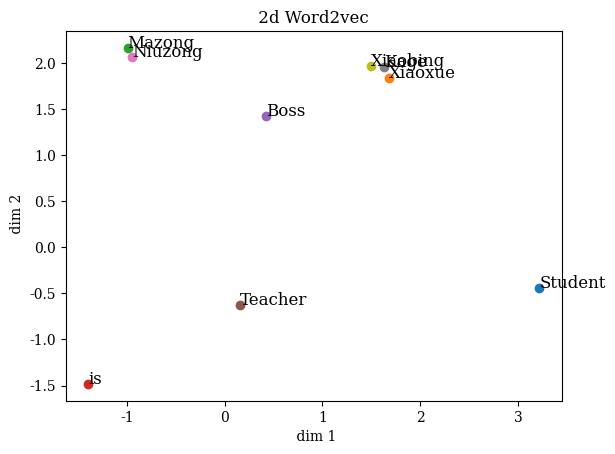

In [25]:
fig, ax = plt.subplots()
for word, idx in word_to_idx.items():
    # 获取每个单词的嵌入向量
    vec = cbow_model.input_to_hidden.weight[:,idx].detach().numpy()
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 点旁添加单词标签
plt.title(' 2d Word2vec ') # 图题
plt.xlabel(' dim 1') # X 轴 Label
plt.ylabel(' dim 2') # Y 轴 Label
plt.show() # 显示图

## Attention

### 1. Dot-product Attention

In [26]:
import torch # 导入 torch
import torch.nn.functional as F # 导入 nn.functional
# 1. 创建两个张量 x1 和 x2
x1 = torch.randn(2, 3, 4) # 形状 (batch_size, seq_len1, feature_dim)
x2 = torch.randn(2, 5, 4) # 形状 (batch_size, seq_len2, feature_dim)
# 2. 计算原始权重
raw_weights = torch.bmm(x1, x2.transpose(1, 2)) # 形状 (batch_size, seq_len1, seq_len2)
# 3. 用 softmax 函数对原始权重进行归一化
attn_weights = F.softmax(raw_weights, dim=2) # 形状 (batch_size, seq_len1, seq_len2)
# 4. 将注意力权重与 x2 相乘，计算加权和
attn_output = torch.bmm(attn_weights, x2)  # 形状 (batch_size, seq_len1, feature_dim)

In [27]:
# 创建两个张量 x1 和 x2
x1 = torch.randn(2, 3, 4) # 形状 (batch_size, seq_len1, feature_dim)
x2 = torch.randn(2, 5, 4) # 形状 (batch_size, seq_len2, feature_dim)
print("x1:", x1)
print("x2:", x2)

x1: tensor([[[ 0.5747, -0.3515, -1.7834, -1.8312],
         [ 0.4990,  0.3687,  0.1405, -0.0976],
         [ 1.3003,  0.6192,  1.4306, -1.9885]],

        [[ 0.4464, -1.1039,  0.2343, -0.8593],
         [-0.1217,  1.1935, -1.2811,  0.4223],
         [ 2.5573, -1.1912, -1.3395, -1.1735]]])
x2: tensor([[[-0.1106, -0.9150,  0.2530,  0.3478],
         [ 0.9827,  0.9912, -0.3135, -0.7296],
         [-0.4740, -0.1598, -0.2564,  2.3042],
         [ 0.6473, -1.2490,  1.0021,  0.0398],
         [-0.6296, -0.3774,  0.1334, -0.7056]],

        [[-0.5303,  0.4038, -0.9813,  0.4828],
         [ 0.6511,  0.4557,  0.1718,  0.2673],
         [-0.8423,  0.3713, -0.5183, -0.6341],
         [ 1.2325,  0.4123,  0.2234, -1.2519],
         [ 0.0810, -1.3998,  0.7149,  0.1671]]])


In [28]:
# 计算点积，得到原始权重，形状为 (batch_size, seq_len1, seq_len2)
raw_weights = torch.bmm(x1, x2.transpose(1, 2))
print(" 原始权重：", raw_weights)

 原始权重： tensor([[[-8.3005e-01,  2.1116e+00, -3.9786e+00, -1.0490e+00,  8.2486e-01],
         [-3.9094e-01,  8.8296e-01, -5.5626e-01, -6.4538e-04, -3.6574e-01],
         [-1.0400e+00,  2.8939e+00, -5.6638e+00,  1.4227e+00,  5.4150e-01]],

        [[-1.3272e+00, -4.0193e-01, -3.6233e-01,  1.2231e+00,  1.6053e+00],
         [ 2.0075e+00,  3.5751e-01,  9.4182e-01, -4.7286e-01, -2.5259e+00],
         [-1.0893e+00,  5.7830e-01, -1.1580e+00,  3.8306e+00,  7.2086e-01]]])


In [29]:
import torch.nn.functional as F # 导入 torch.nn.functional
# 应用 softmax 函数，使权重的值在 0 和 1 之间，且每一行的和为 1
attn_weights = F.softmax(raw_weights, dim=-1) # 归一化
print(" 归一化后的注意力权重：", attn_weights)

 归一化后的注意力权重： tensor([[[3.8424e-02, 7.2800e-01, 1.6490e-03, 3.0869e-02, 2.0106e-01],
         [1.2618e-01, 4.5106e-01, 1.0695e-01, 1.8642e-01, 1.2940e-01],
         [1.4552e-02, 7.4375e-01, 1.4284e-04, 1.7079e-01, 7.0760e-02]],

        [[2.6502e-02, 6.6854e-02, 6.9555e-02, 3.3953e-01, 4.9756e-01],
         [6.1312e-01, 1.1775e-01, 2.1122e-01, 5.1327e-02, 6.5875e-03],
         [6.6519e-03, 3.5253e-02, 6.2105e-03, 9.1123e-01, 4.0654e-02]]])


In [30]:
# 与 x2 相乘，得到注意力分布的加权和，形状为 (batch_size, seq_len1, feature_dim)
attn_output = torch.bmm(attn_weights, x2)
print(" 注意力输出 :", attn_output)

 注意力输出 : tensor([[[ 0.6038,  0.5717, -0.1611, -0.6546],
         [ 0.4178,  0.0329,  0.0672, -0.1227],
         [ 0.7952,  0.4838, -0.0489, -0.5804]],

        [[ 0.4296, -0.4895,  0.3810, -0.3554],
         [-0.3626,  0.3916, -0.6747,  0.1304],
         [ 1.1406,  0.3399,  0.2290, -1.1253]]])


### 2. Self-Attention

In [31]:
import torch
import torch.nn.functional as F
# 一个形状为 (batch_size, seq_len, feature_dim) 的张量 x
x = torch.randn(2, 3, 4)
# 计算原始权重，形状为 (batch_size, seq_len, seq_len)
raw_weights = torch.bmm(x, x.transpose(1, 2))
# 对原始权重进行 softmax 归一化，形状为 (batch_size, seq_len, seq_len)
attn_weights = F.softmax(raw_weights, dim=2)
# 计算加权和，形状为 (batch_size, seq_len, feature_dim)
attn_outputs = torch.bmm(attn_weights, x)

In [32]:
# 一个形状为 (batch_size, seq_len, feature_dim) 的张量 x
x = torch.randn(2, 3, 4) # 形状 (batch_size, seq_len, feature_dim)
# 定义线性层用于将 x 转换为 Q, K, V 向量
linear_q = torch.nn.Linear(4, 4)
linear_k = torch.nn.Linear(4, 4)
linear_v = torch.nn.Linear(4, 4)
# 通过线性层计算 Q, K, V
Q = linear_q(x) # 形状 (batch_size, seq_len, feature_dim)
K = linear_k(x) # 形状 (batch_size, seq_len, feature_dim)
V = linear_v(x) # 形状 (batch_size, seq_len, feature_dim)
# 计算 Q 和 K 的点积，作为相似度分数 , 也就是自注意力原始权重
raw_weights = torch.bmm(Q, K.transpose(1, 2)) # 形状 (batch_size, seq_len, seq_len)
# 将自注意力原始权重进行缩放
scale_factor = K.size(-1) ** 0.5  # 这里是 4 ** 0.5
scaled_weights = raw_weights / scale_factor # 形状 (batch_size, seq_len, seq_len)
# 对缩放后的权重进行 softmax 归一化，得到注意力权重
attn_weights = F.softmax(scaled_weights, dim=2) # 形状 (batch_size, seq_len, seq_len)
# 将注意力权重应用于 V 向量，计算加权和，得到加权信息
attn_outputs = torch.bmm(attn_weights, V) # 形状 (batch_size, seq_len, feature_dim)
print(" 加权信息 :", attn_outputs)

 加权信息 : tensor([[[-0.4641, -0.1968,  0.8148, -0.2394],
         [-0.4866, -0.2000,  0.8693, -0.2887],
         [-0.5226, -0.2030,  0.9611, -0.3744]],

        [[ 0.2660,  0.5328,  0.1547, -0.0852],
         [ 0.2597,  0.4155,  0.1106, -0.0253],
         [ 0.2658,  0.5413,  0.1575, -0.0871]]], grad_fn=<BmmBackward0>)


## Transformers

In [33]:
import numpy as np # 导入 numpy 库
import torch # 导入 torch 库
import torch.nn as nn # 导入 torch.nn 库
d_k = 64 # K(=Q) 维度
d_v = 64 # V 维度
# 定义缩放点积注意力类
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    def forward(self, Q, K, V, attn_mask):
        #------------------------- 维度信息 --------------------------------
        # Q K V [batch_size, n_heads, len_q/k/v, dim_q=k/v] (dim_q=dim_k)
        # attn_mask [batch_size, n_heads, len_q, len_k]
        #----------------------------------------------------------------
        # 计算注意力分数（原始权重）[batch_size，n_heads，len_q，len_k]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        #------------------------- 维度信息 --------------------------------
        # scores [batch_size, n_heads, len_q, len_k]
        #-----------------------------------------------------------------
        # 使用注意力掩码，将 attn_mask 中值为 1 的位置的权重替换为极小值
        #------------------------- 维度信息 --------------------------------
        # attn_mask [batch_size, n_heads, len_q, len_k], 形状和 scores 相同
        #-----------------------------------------------------------------
        scores.masked_fill_(attn_mask, -1e9)
        # 对注意力分数进行 softmax 归一化
        weights = nn.Softmax(dim=-1)(scores)
        #------------------------- 维度信息 --------------------------------
        # weights [batch_size, n_heads, len_q, len_k], 形状和 scores 相同
        #-----------------------------------------------------------------
        # 计算上下文向量（也就是注意力的输出）, 是上下文信息的紧凑表示
        context = torch.matmul(weights, V)
        #------------------------- 维度信息 --------------------------------
        # context [batch_size, n_heads, len_q, dim_v]
        #-----------------------------------------------------------------
        return context, weights # 返回上下文向量和注意力分数

In [34]:
# 定义多头自注意力类
d_embedding = 512  # Embedding 的维度
n_heads = 8  # Multi-Head Attention 中头的个数
batch_size = 3 # 每一批的数据大小
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_embedding, d_k * n_heads) # Q的线性变换层
        self.W_K = nn.Linear(d_embedding, d_k * n_heads) # K的线性变换层
        self.W_V = nn.Linear(d_embedding, d_v * n_heads) # V的线性变换层
        self.linear = nn.Linear(n_heads * d_v, d_embedding)
        self.layer_norm = nn.LayerNorm(d_embedding)
    def forward(self, Q, K, V, attn_mask):
        #------------------------- 维度信息 --------------------------------
        # Q K V [batch_size, len_q/k/v, embedding_dim]
        #-----------------------------------------------------------------
        residual, batch_size = Q, Q.size(0) # 保留残差连接
        # 将输入进行线性变换和重塑，以便后续处理
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)
        #------------------------- 维度信息 --------------------------------
        # q_s k_s v_s: [batch_size, n_heads, len_q/k/v, d_q=k/v]
        #-----------------------------------------------------------------
        # 将注意力掩码复制到多头 attn_mask: [batch_size, n_heads, len_q, len_k]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        #------------------------- 维度信息 --------------------------------
        # attn_mask [batch_size, n_heads, len_q, len_k]
        #-----------------------------------------------------------------
        # 使用缩放点积注意力计算上下文和注意力权重
        context, weights = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        #------------------------- 维度信息 --------------------------------
        # context [batch_size, n_heads, len_q, dim_v]
        # weights [batch_size, n_heads, len_q, len_k]
        #-----------------------------------------------------------------
        # 通过调整维度将多个头的上下文向量连接在一起
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v)
        #------------------------- 维度信息 --------------------------------
        # context [batch_size, len_q, n_heads * dim_v]
        #-----------------------------------------------------------------
        # 用一个线性层把连接后的多头自注意力结果转换，原始地嵌入维度
        output = self.linear(context)
        #------------------------- 维度信息 --------------------------------
        # output [batch_size, len_q, embedding_dim]
        #-----------------------------------------------------------------
        # 与输入 (Q) 进行残差链接，并进行层归一化后输出
        output = self.layer_norm(output + residual)
        #------------------------- 维度信息 --------------------------------
        # output [batch_size, len_q, embedding_dim]
        #-----------------------------------------------------------------
        return output, weights # 返回层归一化的输出和注意力权重

In [35]:
# 定义逐位置前馈网络类
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_ff=2048):
        super(PoswiseFeedForwardNet, self).__init__()
        # 定义一维卷积层 1，用于将输入映射到更高维度
        self.conv1 = nn.Conv1d(in_channels=d_embedding, out_channels=d_ff, kernel_size=1)
        # 定义一维卷积层 2，用于将输入映射回原始维度
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_embedding, kernel_size=1)
        # 定义层归一化
        self.layer_norm = nn.LayerNorm(d_embedding)
    def forward(self, inputs):
        #------------------------- 维度信息 --------------------------------
        # inputs [batch_size, len_q, embedding_dim]
        #----------------------------------------------------------------
        residual = inputs  # 保留残差连接
        # 在卷积层 1 后使用 ReLU 激活函数
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        #------------------------- 维度信息 --------------------------------
        # output [batch_size, d_ff, len_q]
        #----------------------------------------------------------------
        # 使用卷积层 2 进行降维
        output = self.conv2(output).transpose(1, 2)
        #------------------------- 维度信息 --------------------------------
        # output [batch_size, len_q, embedding_dim]
        #----------------------------------------------------------------
        # 与输入进行残差链接，并进行层归一化
        output = self.layer_norm(output + residual)
        #------------------------- 维度信息 --------------------------------
        # output [batch_size, len_q, embedding_dim]
        #----------------------------------------------------------------
        return output # 返回加入残差连接后层归一化的结果

In [36]:
# 生成正弦位置编码表的函数，用于在 Transformer 中引入位置信息
def get_sin_enc_table(n_position, embedding_dim):
    #------------------------- 维度信息 --------------------------------
    # n_position: 输入序列的最大长度
    # embedding_dim: 词嵌入向量的维度
    #-----------------------------------------------------------------
    # 根据位置和维度信息，初始化正弦位置编码表
    sinusoid_table = np.zeros((n_position, embedding_dim))
    # 遍历所有位置和维度，计算角度值
    for pos_i in range(n_position):
        for hid_j in range(embedding_dim):
            angle = pos_i / np.power(10000, 2 * (hid_j // 2) / embedding_dim)
            sinusoid_table[pos_i, hid_j] = angle
    # 计算正弦和余弦值
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i 偶数维
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1 奇数维
    #------------------------- 维度信息 --------------------------------
    # sinusoid_table 的维度是 [n_position, embedding_dim]
    #----------------------------------------------------------------
    return torch.FloatTensor(sinusoid_table)  # 返回正弦位置编码表

In [37]:
# 定义填充注意力掩码函数
def get_attn_pad_mask(seq_q, seq_k):
    #------------------------- 维度信息 --------------------------------
    # seq_q 的维度是 [batch_size, len_q]
    # seq_k 的维度是 [batch_size, len_k]
    #-----------------------------------------------------------------
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # 生成布尔类型张量
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # <PAD>token 的编码值为 0
    #------------------------- 维度信息 --------------------------------
    # pad_attn_mask 的维度是 [batch_size，1，len_k]
    #-----------------------------------------------------------------
    # 变形为与注意力分数相同形状的张量
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k)
    #------------------------- 维度信息 --------------------------------
    # pad_attn_mask 的维度是 [batch_size，len_q，len_k]
    #-----------------------------------------------------------------
    return pad_attn_mask

In [38]:
# 定义编码器层类
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention() # 多头自注意力层
        self.pos_ffn = PoswiseFeedForwardNet() # 位置前馈神经网络层
    def forward(self, enc_inputs, enc_self_attn_mask):
        #------------------------- 维度信息 --------------------------------
        # enc_inputs 的维度是 [batch_size, seq_len, embedding_dim]
        # enc_self_attn_mask 的维度是 [batch_size, seq_len, seq_len]
        #-----------------------------------------------------------------
        # 将相同的 Q，K，V 输入多头自注意力层 , 返回的 attn_weights 增加了头数
        enc_outputs, attn_weights = self.enc_self_attn(enc_inputs, enc_inputs,
                                               enc_inputs, enc_self_attn_mask)
        #------------------------- 维度信息 --------------------------------
        # enc_outputs 的维度是 [batch_size, seq_len, embedding_dim]
        # attn_weights 的维度是 [batch_size, n_heads, seq_len, seq_len]
        # 将多头自注意力 outputs 输入位置前馈神经网络层
        enc_outputs = self.pos_ffn(enc_outputs) # 维度与 enc_inputs 相同
        #------------------------- 维度信息 --------------------------------
        # enc_outputs 的维度是 [batch_size, seq_len, embedding_dim]
        #-----------------------------------------------------------------
        return enc_outputs, attn_weights # 返回编码器输出和每层编码器注意力权重

In [39]:
# 定义编码器类
n_layers = 6  # 设置 Encoder 的层数
class Encoder(nn.Module):
    def __init__(self, corpus):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(len(corpus.src_vocab), d_embedding) # 词嵌入层
        self.pos_emb = nn.Embedding.from_pretrained( \
          get_sin_enc_table(corpus.src_len+1, d_embedding), freeze=True) # 位置嵌入层
        self.layers = nn.ModuleList(EncoderLayer() for _ in range(n_layers))# 编码器层数
    def forward(self, enc_inputs):
        #------------------------- 维度信息 --------------------------------
        # enc_inputs 的维度是 [batch_size, source_len]
        #-----------------------------------------------------------------
        # 创建一个从 1 到 source_len 的位置索引序列
        pos_indices = torch.arange(1, enc_inputs.size(1) + 1).unsqueeze(0).to(enc_inputs)
        #------------------------- 维度信息 --------------------------------
        # pos_indices 的维度是 [1, source_len]
        #-----------------------------------------------------------------
        # 对输入进行词嵌入和位置嵌入相加 [batch_size, source_len，embedding_dim]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(pos_indices)
        #------------------------- 维度信息 --------------------------------
        # enc_outputs 的维度是 [batch_size, seq_len, embedding_dim]
        #-----------------------------------------------------------------
        # 生成自注意力掩码
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        #------------------------- 维度信息 --------------------------------
        # enc_self_attn_mask 的维度是 [batch_size, len_q, len_k]
        #-----------------------------------------------------------------
        enc_self_attn_weights = [] # 初始化 enc_self_attn_weights
        # 通过编码器层 [batch_size, seq_len, embedding_dim]
        for layer in self.layers:
            enc_outputs, enc_self_attn_weight = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attn_weights.append(enc_self_attn_weight)
        #------------------------- 维度信息 --------------------------------
        # enc_outputs 的维度是 [batch_size, seq_len, embedding_dim] 维度与 enc_inputs 相同
        # enc_self_attn_weights 是一个列表，每个元素的维度是 [batch_size, n_heads, seq_len, seq_len]
        #-----------------------------------------------------------------
        return enc_outputs, enc_self_attn_weights # 返回编码器输出和编码器注意力权重

In [40]:
# 生成后续注意力掩码的函数，用于在多头自注意力计算中忽略未来信息
def get_attn_subsequent_mask(seq):
    #------------------------- 维度信息 --------------------------------
    # seq 的维度是 [batch_size, seq_len(Q)=seq_len(K)]
    #-----------------------------------------------------------------
    # 获取输入序列的形状
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    #------------------------- 维度信息 --------------------------------
    # attn_shape 是一个一维张量 [batch_size, seq_len(Q), seq_len(K)]
    #-----------------------------------------------------------------
    # 使用 numpy 创建一个上三角矩阵（triu = triangle upper）
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    #------------------------- 维度信息 --------------------------------
    # subsequent_mask 的维度是 [batch_size, seq_len(Q), seq_len(K)]
    #-----------------------------------------------------------------
    # 将 numpy 数组转换为 PyTorch 张量，并将数据类型设置为 byte（布尔值）
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    #------------------------- 维度信息 --------------------------------
    # 返回的 subsequent_mask 的维度是 [batch_size, seq_len(Q), seq_len(K)]
    #-----------------------------------------------------------------
    return subsequent_mask # 返回后续位置的注意力掩码

In [41]:
# 定义解码器层类
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention() # 多头自注意力层
        self.dec_enc_attn = MultiHeadAttention()  # 多头自注意力层，连接编码器和解码器
        self.pos_ffn = PoswiseFeedForwardNet() # 位置前馈神经网络层
    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        #------------------------- 维度信息 --------------------------------
        # dec_inputs 的维度是 [batch_size, target_len, embedding_dim]
        # enc_outputs 的维度是 [batch_size, source_len, embedding_dim]
        # dec_self_attn_mask 的维度是 [batch_size, target_len, target_len]
        # dec_enc_attn_mask 的维度是 [batch_size, target_len, source_len]
        #-----------------------------------------------------------------
        # 将相同的 Q，K，V 输入多头自注意力层
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs,
                                                        dec_inputs, dec_self_attn_mask)
        #------------------------- 维度信息 --------------------------------
        # dec_outputs 的维度是 [batch_size, target_len, embedding_dim]
        # dec_self_attn 的维度是 [batch_size, n_heads, target_len, target_len]
        #-----------------------------------------------------------------
        # 将解码器输出和编码器输出输入多头自注意力层
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs,
                                                      enc_outputs, dec_enc_attn_mask)
        #------------------------- 维度信息 --------------------------------
        # dec_outputs 的维度是 [batch_size, target_len, embedding_dim]
        # dec_enc_attn 的维度是 [batch_size, n_heads, target_len, source_len]
        #-----------------------------------------------------------------
        # 输入位置前馈神经网络层
        dec_outputs = self.pos_ffn(dec_outputs)
        #------------------------- 维度信息 --------------------------------
        # dec_outputs 的维度是 [batch_size, target_len, embedding_dim]
        # dec_self_attn 的维度是 [batch_size, n_heads, target_len, target_len]
        # dec_enc_attn 的维度是 [batch_size, n_heads, target_len, source_len]
        #-----------------------------------------------------------------
        # 返回解码器层输出，每层的自注意力和解 - 编码器注意力权重
        return dec_outputs, dec_self_attn, dec_enc_attn

In [42]:
#  定义解码器类
n_layers = 6  # 设置 Decoder 的层数
class Decoder(nn.Module):
    def __init__(self, corpus):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(len(corpus.tgt_vocab), d_embedding) # 词嵌入层
        self.pos_emb = nn.Embedding.from_pretrained( \
           get_sin_enc_table(corpus.tgt_len+1, d_embedding), freeze=True) # 位置嵌入层
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)]) # 叠加多层
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        #------------------------- 维度信息 --------------------------------
        # dec_inputs 的维度是 [batch_size, target_len]
        # enc_inputs 的维度是 [batch_size, source_len]
        # enc_outputs 的维度是 [batch_size, source_len, embedding_dim]
        #-----------------------------------------------------------------
        # 创建一个从 1 到 source_len 的位置索引序列
        pos_indices = torch.arange(1, dec_inputs.size(1) + 1).unsqueeze(0).to(dec_inputs)
        #------------------------- 维度信息 --------------------------------
        # pos_indices 的维度是 [1, target_len]
        #-----------------------------------------------------------------
        # 对输入进行词嵌入和位置嵌入相加
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(pos_indices)
        #------------------------- 维度信息 --------------------------------
        # dec_outputs 的维度是 [batch_size, target_len, embedding_dim]
         #-----------------------------------------------------------------
        # 生成解码器自注意力掩码和解码器 - 编码器注意力掩码
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs) # 填充位掩码
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs) # 后续位掩码
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask \
                                       + dec_self_attn_subsequent_mask), 0)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs) # 解码器 - 编码器掩码
        #------------------------- 维度信息 --------------------------------
        # dec_self_attn_pad_mask 的维度是 [batch_size, target_len, target_len]
        # dec_self_attn_subsequent_mask 的维度是 [batch_size, target_len, target_len]
        # dec_self_attn_mask 的维度是 [batch_size, target_len, target_len]
        # dec_enc_attn_mask 的维度是 [batch_size, target_len, source_len]
         #-----------------------------------------------------------------
        dec_self_attns, dec_enc_attns = [], [] # 初始化 dec_self_attns, dec_enc_attns
        # 通过解码器层 [batch_size, seq_len, embedding_dim]
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs,
                                               dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        #------------------------- 维度信息 --------------------------------
        # dec_outputs 的维度是 [batch_size, target_len, embedding_dim]
        # dec_self_attns 是一个列表，每个元素的维度是 [batch_size, n_heads, target_len, target_len]
        # dec_enc_attns 是一个列表，每个元素的维度是 [batch_size, n_heads, target_len, source_len]
        #-----------------------------------------------------------------
        # 返回解码器输出，解码器自注意力和解码器 - 编码器注意力权重
        return dec_outputs, dec_self_attns, dec_enc_attns

In [43]:
# 定义 Transformer 模型
class Transformer(nn.Module):
    def __init__(self, corpus):
        super(Transformer, self).__init__()
        self.encoder = Encoder(corpus) # 初始化编码器实例
        self.decoder = Decoder(corpus) # 初始化解码器实例
        # 定义线性投影层，将解码器输出转换为目标词汇表大小的概率分布
        self.projection = nn.Linear(d_embedding, len(corpus.tgt_vocab), bias=False)
    def forward(self, enc_inputs, dec_inputs):
        #------------------------- 维度信息 --------------------------------
        # enc_inputs 的维度是 [batch_size, source_seq_len]
        # dec_inputs 的维度是 [batch_size, target_seq_len]
        #-----------------------------------------------------------------
        # 将输入传递给编码器，并获取编码器输出和自注意力权重
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        #------------------------- 维度信息 --------------------------------
        # enc_outputs 的维度是 [batch_size, source_len, embedding_dim]
        # enc_self_attns 是一个列表，每个元素的维度是 [batch_size, n_heads, src_seq_len, src_seq_len]
        #-----------------------------------------------------------------
        # 将编码器输出、解码器输入和编码器输入传递给解码器
        # 获取解码器输出、解码器自注意力权重和编码器 - 解码器注意力权重
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        #------------------------- 维度信息 --------------------------------
        # dec_outputs 的维度是 [batch_size, target_len, embedding_dim]
        # dec_self_attns 是一个列表，每个元素的维度是 [batch_size, n_heads, tgt_seq_len, src_seq_len]
        # dec_enc_attns 是一个列表，每个元素的维度是 [batch_size, n_heads, tgt_seq_len, src_seq_len]
        #-----------------------------------------------------------------
        # 将解码器输出传递给投影层，生成目标词汇表大小的概率分布
        dec_logits = self.projection(dec_outputs)
        #------------------------- 维度信息 --------------------------------
        # dec_logits 的维度是 [batch_size, tgt_seq_len, tgt_vocab_size]
        #-----------------------------------------------------------------
        # 返回逻辑值 ( 原始预测结果 ), 编码器自注意力权重，解码器自注意力权重，解 - 编码器注意力权重
        return dec_logits, enc_self_attns, dec_self_attns, dec_enc_attns

In [48]:
sentences = [
    ['我 喜欢 港科大广州', 'I likes HKUST-GZ'],
    ['我 爱 学习 自然语言处理', 'I love studying NLP'],
    ['深度学习 改变 世界', ' DL changed the world'],
    ['自然语言处理 很 强大', 'NLP is powerful'],
    ['神经网络 非常 复杂', 'Neural-networks are complex'] ]

- Train on a simple translation tasks

In [49]:
from collections import Counter # 导入 Counter 类
# 定义 TranslationCorpus 类
class TranslationCorpus:
    def __init__(self, sentences):
        self.sentences = sentences
        # 计算源语言和目标语言的最大句子长度，并分别加 1 和 2 以容纳填充符和特殊符号
        self.src_len = max(len(sentence[0].split()) for sentence in sentences) + 1
        self.tgt_len = max(len(sentence[1].split()) for sentence in sentences) + 2
        # 创建源语言和目标语言的词汇表
        self.src_vocab, self.tgt_vocab = self.create_vocabularies()
        # 创建索引到单词的映射
        self.src_idx2word = {v: k for k, v in self.src_vocab.items()}
        self.tgt_idx2word = {v: k for k, v in self.tgt_vocab.items()}
    # 定义创建词汇表的函数
    def create_vocabularies(self):
        # 统计源语言和目标语言的单词频率
        src_counter = Counter(word for sentence in self.sentences for word in sentence[0].split())
        tgt_counter = Counter(word for sentence in self.sentences for word in sentence[1].split())
        # 创建源语言和目标语言的词汇表，并为每个单词分配一个唯一的索引
        src_vocab = {'<pad>': 0, **{word: i+1 for i, word in enumerate(src_counter)}}
        tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2,
                     **{word: i+3 for i, word in enumerate(tgt_counter)}}
        return src_vocab, tgt_vocab
    # 定义创建批次数据的函数
    def make_batch(self, batch_size, test_batch=False):
        input_batch, output_batch, target_batch = [], [], []
        # 随机选择句子索引
        sentence_indices = torch.randperm(len(self.sentences))[:batch_size]
        for index in sentence_indices:
            src_sentence, tgt_sentence = self.sentences[index]
            # 将源语言和目标语言的句子转换为索引序列
            src_seq = [self.src_vocab[word] for word in src_sentence.split()]
            tgt_seq = [self.tgt_vocab['<sos>']] + [self.tgt_vocab[word] \
                         for word in tgt_sentence.split()] + [self.tgt_vocab['<eos>']]
            # 对源语言和目标语言的序列进行填充
            src_seq += [self.src_vocab['<pad>']] * (self.src_len - len(src_seq))
            tgt_seq += [self.tgt_vocab['<pad>']] * (self.tgt_len - len(tgt_seq))
            # 将处理好的序列添加到批次中
            input_batch.append(src_seq)
            output_batch.append([self.tgt_vocab['<sos>']] + ([self.tgt_vocab['<pad>']] * \
                                    (self.tgt_len - 2)) if test_batch else tgt_seq[:-1])
            target_batch.append(tgt_seq[1:])
          # 将批次转换为 LongTensor 类型
        input_batch = torch.LongTensor(input_batch)
        output_batch = torch.LongTensor(output_batch)
        target_batch = torch.LongTensor(target_batch)
        return input_batch, output_batch, target_batch
# 创建语料库类实例
corpus = TranslationCorpus(sentences)

In [50]:
import torch # 导入 torch
import torch.optim as optim # 导入优化器
model = Transformer(corpus) # 创建模型实例
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = optim.Adam(model.parameters(), lr=0.0001) # 优化器
epochs = 5 # 训练轮次
for epoch in range(epochs): # 训练 100 轮
    optimizer.zero_grad() # 梯度清零
    enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size) # 创建训练数据
    outputs, _, _, _ = model(enc_inputs, dec_inputs) # 获取模型输出
    loss = criterion(outputs.view(-1, len(corpus.tgt_vocab)), target_batch.view(-1)) # 计算损失
    if (epoch + 1) % 1 == 0: # 打印损失
        print(f"Epoch: {epoch + 1:04d} cost = {loss:.6f}")
    loss.backward()# 反向传播
    optimizer.step()# 更新参数

Epoch: 0001 cost = 3.288968
Epoch: 0002 cost = 2.416078
Epoch: 0003 cost = 1.616275
Epoch: 0004 cost = 2.574568
Epoch: 0005 cost = 2.334296


In [51]:
# 创建一个大小为 1 的批次，目标语言序列 dec_inputs 在测试阶段，仅包含句子开始符号 <sos>
enc_inputs, dec_inputs, target_batch = corpus.make_batch(batch_size=1,test_batch=True)
print("编码器输入 :", enc_inputs) # 打印编码器输入
print("解码器输入 :", dec_inputs) # 打印解码器输入
print("目标数据 :", target_batch) # 打印目标数据
predict, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs) # 用模型进行翻译
predict = predict.view(-1, len(corpus.tgt_vocab)) # 将预测结果维度重塑
predict = predict.data.max(1, keepdim=True)[1] # 找到每个位置概率最大的词汇的索引
# 解码预测的输出，将所预测的目标句子中的索引转换为单词
translated_sentence = [corpus.tgt_idx2word[idx.item()] for idx in predict.squeeze()]
# 将输入的源语言句子中的索引转换为单词
input_sentence = ' '.join([corpus.src_idx2word[idx.item()] for idx in enc_inputs[0]])
print(input_sentence, '->', translated_sentence) # 打印原始句子和翻译后的句子

编码器输入 : tensor([[12, 13, 14,  0,  0]])
解码器输入 : tensor([[1, 0, 0, 0, 0]])
目标数据 : tensor([[15, 16, 17,  2,  0]])
神经网络 非常 复杂 <pad> <pad> -> ['Neural-networks', 'Neural-networks', 'Neural-networks', 'Neural-networks', 'Neural-networks']
